In [55]:
import pandas as pd 
import numpy as np

In [56]:
data=pd.read_csv(r"C:\Users\SAKET NANDAN\Documents\current_excelr_lms\logistic_regression_assignment\creditcard.csv")

In [57]:
data.isnull().sum()

Unnamed: 0     0
card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [58]:
    data.drop(labels='Unnamed: 0', axis=1,inplace=True)

In [59]:
#data

In [60]:
#some of the encoder can not able to create realtion ship with categorical type target , so here i m using custom fuction to make the 
#the target as integer 
#target is labeled as integer then no need to do this transformation 

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def integer_encode(data,  variable, ordinal_mapping):

    data[variable] = data[variable].map(ordinal_mapping)


In [61]:
for variable in ['card']:
    mappings = find_category_mappings(data, variable)
    integer_encode(data, variable, mappings)

In [62]:
#data

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
# Let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels='card', axis=1),  # predictors
    data['card'],  # target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((923, 11), (396, 11))

In [65]:
# find categorical variables

categorical = [var for var in X_train.columns if X_train[var].dtype =='O']

print('There are {} categorical variables in training set.\n'.format(len(categorical)))

print('The categorical variables are :', categorical)

There are 2 categorical variables in training set.

The categorical variables are : ['owner', 'selfemp']


In [66]:
# find numerical variables

numerical = [var for var in X_train.columns if X_train[var].dtype !='O']

print('There are {} numerical variables in training set.\n'.format(len(numerical)))

print('The numerical variables are :', numerical)

There are 9 numerical variables in training set.

The numerical variables are : ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']


### weight of evidence encoding

In [67]:
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder

In [68]:
woe_enc = WoERatioCategoricalEncoder(
    encoding_method = 'woe',
    variables=categorical)

In [69]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

woe_enc.fit(X_train, y_train)

WoERatioCategoricalEncoder(encoding_method='woe',
                           variables=['owner', 'selfemp'])

In [71]:
X_train_woe = woe_enc.transform(X_train)
X_test_woe = woe_enc.transform(X_test)

### ordered integer encoding

In [72]:
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [73]:
ordinal_enc = OrdinalCategoricalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables=categorical)

In [74]:
ordinal_enc.fit(X_train,y_train)

OrdinalCategoricalEncoder(encoding_method='ordered',
                          variables=['owner', 'selfemp'])

In [76]:
X_train_ordered = ordinal_enc.transform(X_train)
X_test_ordered = ordinal_enc.transform(X_test)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [81]:
def run_logistic(X_train, X_test, y_train, y_test):

    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44, C=0.01)
    logit.fit(X_train, y_train)

    print('Train set')
    pred = logit.predict_proba(X_train)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(X_test)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [82]:
# ordered labels
run_logistic(X_train_ordered, X_test_ordered, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.996363155458573
Test set
Logistic Regression roc-auc: 0.9956888255898995


C:\Users\SAKET NANDAN\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
#woe encoding
run_logistic(X_train_woe, X_test_woe, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9963499305693315
Test set
Logistic Regression roc-auc: 0.9956888255898995


C:\Users\SAKET NANDAN\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### feature selection

In [84]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

In [85]:
X_train=X_train_woe.copy()
X_test=X_test_woe.copy()
y_train=y_train.copy()
y_test=y_test.copy()

In [86]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook
X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [87]:
#before removing constatnt features
X_train.shape,X_test.shape

((923, 11), (396, 11))

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [91]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
 
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((923, 11), (396, 11))

### Remove duplicated features

In [92]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)
 
    col_1 = X_train.columns[i]
 
    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)#no of duplicate features?

0
10


0

In [93]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((923, 11), (396, 11))

In [94]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook
 
X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [95]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
 
corr_features = correlation(X_train, 0.85)
print('correlated features: ', len(set(corr_features)) )

correlated features:  1


In [96]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((923, 10), (396, 10))

In [97]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Remove features using univariate ROC-AUC

In [98]:
# find important features using univariate roc-auc
 
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
 
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

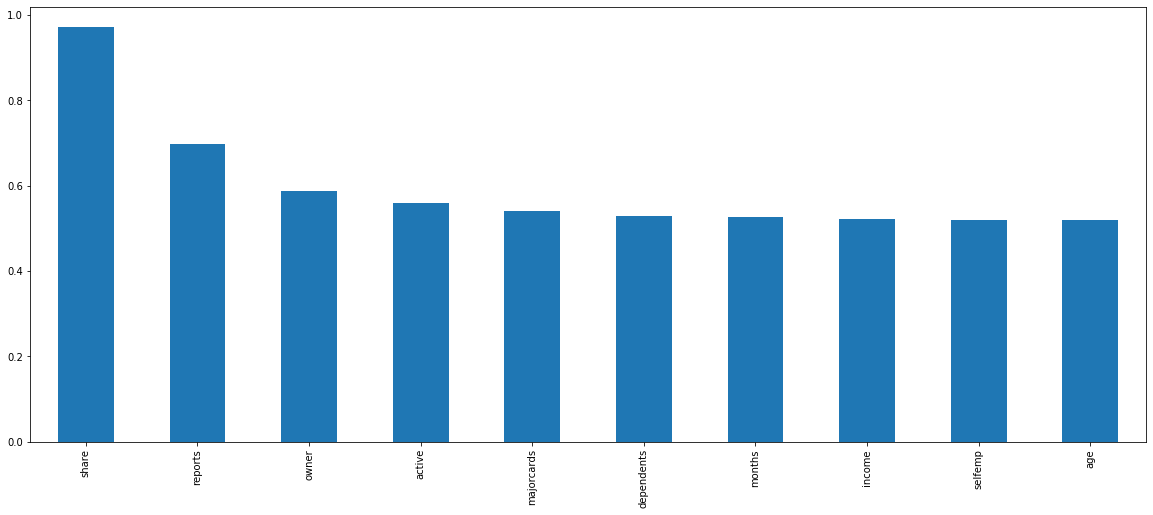

In [99]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [100]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features
 
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(10, 10)

### Remove features using Lasso

In [101]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [102]:
# fit a lasso and select features, make sure to select l1
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(X_train), y_train)
 
# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))
 
# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]

In [103]:
X_train_lasso.shape, X_test_lasso.shape

((923, 2), (396, 2))

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
# create a function to build logistic regression and compare performance in train and test set
 
def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [106]:
# original
scaler = StandardScaler().fit(X_train_original)
 
run_logistic(scaler.transform(X_train_original),
             scaler.transform(X_test_original),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9886596574753687
Test set
Logistic Regression roc-auc: 0.9800993109819469


In [107]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter)
 
run_logistic(scaler.transform(X_train_basic_filter),
             scaler.transform(X_test_basic_filter),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9886596574753687
Test set
Logistic Regression roc-auc: 0.9800993109819469


In [108]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr)
 
run_logistic(scaler.transform(X_train_corr),
             scaler.transform(X_test_corr),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9851418369371157
Test set
Logistic Regression roc-auc: 0.9749028061126295


In [109]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])
 
run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9851418369371157
Test set
Logistic Regression roc-auc: 0.9749028061126295


In [114]:
# embedded methods - Lasso
run_logistic(X_train_lasso,
             X_test_lasso,
                  y_train, y_test)


Train set
Logistic Regression roc-auc: 0.9487436355220523
Test set
Logistic Regression roc-auc: 0.9342160976173063


In [115]:
X_train_lasso.columns

Index(['reports', 'share'], dtype='object')